### Table of contents
[Predefined functions](#funcs)

[Parameters, filenames and directories](#params)

[Reading maps and catalogs](#read)

[Function for plotting statistics for different outlCoeff](#plotStatOutlCoeff)

[SpecZ outlier filtering](#specZ)

[PhotoZ_ML outlier filtering](#photoZ_ML)

[PhotoZ_SED outlier filtering](#photoZ_SED)

[ActivMap filtering](#activMap)

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from func_maps import readMaps
from func_stat import *
from func_visualizations import *
from os.path import join
from ast import literal_eval

### Parameters, filenames and directories
<a id='params'>#params</a>

In [2]:
### Files and directories ###
dirSOM=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\SOM\forArticle'
nameOfExperiment='ex018'
dirMaps=join(dirSOM,nameOfExperiment,'maps')
dirPlots=join(dirSOM,nameOfExperiment,'plots')
dirDatasets=join(dirSOM,nameOfExperiment,'datasets')
mapsAllKeys=['mapsTrainOnTrain','mapsTestOnTrain','mapsDeimosOnTrain','mapsRunOnTrain',
             'mapsTrainOnRun','mapsTestOnRun','mapsDeimosOnRun','mapsRunOnRun',
             'mapsTrainOnRunBig','mapsTestOnRunBig','mapsDeimosOnRunBig','mapsRunOnRunBig']

In [3]:
datasetNames={'Train':r'05_COSMOS_SpectrZ_Zlim_1p2_SOMinfo.csv',
              'Test':r'05_COSMOS_SpectrZ_Zlim_1p2_Test_SOMinfo.csv',
              'Deimos':r'04_COSMOS_DEIMOS_QfFilter_SOMinfo.csv',
              'Run':r'04_COSMOS2015_run_WorkBands_SOMinfo.csv'}

In [4]:
idCol='Seq'
specZ='specZ'
photoZ_ML='photoZ_ML'
photoZ_SED='photoZ_SED'
residML='resid_ML'
residSED='resid_SED'
residML_SED='residML_SED'
quantErr='quantErr'

In [5]:
### Format for saving images ###
imSaveFormat='.png'
#imSaveFormat='.eps'

### Reading datasets
<a id='read'>#read</a>

In [6]:
datasets={}
cellIDs=['cellID_TrainSOM','cellID_RunSOM','cellID_RunBigSOM']
for key,val in datasetNames.items():
    datasets[key]=pd.read_csv(join(dirDatasets,val))
    for cellID in cellIDs:
        datasets[key][cellID]=[literal_eval(x) for x in datasets[key][cellID]]

### Calculating statistics
<a id='statDeclare'>#statDeclare</a>
<p>Since we have a bit too many statistical tables, they are stashed in one dictionary. It's structure is as follows:</p>
    <br>Dictionary statAll has keys which correspond to datasets.
    <br>For each key we have a dictionary which keys correspond to stat table names. We have: 
    <br>- 'basic' table, which corresponds to different cases of cleaning (None, SpecZ, PhotoZ, activMap and their combinations);
    <br>- 'magBin' table, which describes statistics within magnitude bins;
    <br>- 'oultCoeff' for specZ, SED and ML photoZ, which describe statistics within each bin of outlier coefficients;
    <br>- 'activMap' table, which describes statistics for different occupations of cells;
    <br>- probably something else.

In [7]:
statAll={name:{} for name in datasetNames.keys()}

In [38]:
### Calculate statistics for general cases: no filtering, specZ/photoZ/activMap filterings ###
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
        colsFilt=[photoZ_ML+'_outlCoeff',photoZ_SED+'_outlCoeff']
    else:
        residCols=[residML,residSED,residML_SED]
        colsFilt=[specZ+'_outlCoeff',photoZ_ML+'_outlCoeff',photoZ_SED+'_outlCoeff']

    statAll[name]['Basic']=createStatTab(residCols,indexName='case')
    
    data=datasets[name]
    statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case='No filtering',data=data,
                                             residCols=residCols)
    data=datasets[name][datasets[name]['trainMapOccupation']>5]
    statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case='trainMapOccupation>5',data=data,
                                             residCols=residCols)
    for col in colsFilt:
        data=datasets[name][datasets[name][col].abs()<=1]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+'<=1',data=data,
                                             residCols=residCols)
        data=data[data['trainMapOccupation']>5]
        statAll[name]['Basic']=allStatsAddRec(statAll[name]['Basic'],case=col+' + occupation filters',data=data,
                                             residCols=residCols)
    

In [9]:
### Calculate statistics by magnitude bins ###
numBins=40
bins=np.linspace(16, 28, numBins)
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
    else:
        residCols=[residML,residSED,residML_SED]
    statAll[name]['magBins']=statByBins(datasets[name],binCol='ipmagap3',residCols=residCols,bins=bins)

In [10]:
### Calculate statistics for objects with different outlCoeff ###
cases=[specZ,photoZ_ML,photoZ_SED]
residCols=[residML,residSED,residML_SED]
bins=np.arange(-5, 5.5,step=0.5)
for name in statAll.keys():
    for c in cases:
        if name=='Run':
            if c==specZ:
                continue
            else:
                statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=[residML_SED],bins=bins)
        else:
            statAll[name]['outlCoeff_'+c]=statByBins(datasets[name],binCol=c+'_outlCoeff',residCols=residCols,bins=bins)

In [11]:
### Calculate statistics for objects from cells with different occupation by objects from train dataset ###
residCols=[residML,residSED,residML_SED]
bins=sorted(datasets['Train']['trainMapOccupation'].unique())
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
    else:
        residCols=[residML,residSED,residML_SED]

    statAll[name]['activMap']=createStatTab(residCols,addCols=['trainMapOccupation'])
    for b in bins:
        data=datasets[name][datasets[name]['trainMapOccupation']==b]
        if len(data)>0:
            statAll[name]['activMap']=allStatsAddRec(statAll[name]['activMap'],case=b,data=data,
                                             residCols=residCols,addCols={'trainMapOccupation':b})

In [39]:
### Calculate statistics by magnitude bins for different cleaning cases###
numBins=40
bins=np.linspace(16, 28, numBins)
for name in statAll.keys():
    if name=='Run':
        residCols=[residML_SED]
        data=datasets[name][datasets[name][photoZ_SED+'_outlCoeff'].abs()<=1]
        statAll[name]['magBins_photoZ_SED_filt']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name]['trainMapOccupation']>5]
        statAll[name]['magBins_activMap']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name][photoZ_SED+'_outlCoeff'].abs()<=1]
        data=data[data['trainMapOccupation']>5]
        statAll[name]['magBins_activMap_photoZ_SED']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)
    else:
        residCols=[residML,residSED,residML_SED]
        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        statAll[name]['magBins_specZ_filt']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name]['trainMapOccupation']>5]
        statAll[name]['magBins_activMap']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)

        data=datasets[name][datasets[name][specZ+'_outlCoeff'].abs()<=1]
        data=data[data['trainMapOccupation']>5]
        statAll[name]['magBins_activMap_specZ']=statByBins(data,binCol='ipmagap3',residCols=residCols,bins=bins)
    
    

### Function for plotting statistics for different outlCoeff
<a id='plotStatOutlCoeff'>#plotStatOutlCoeff</a>

In [60]:
def plotStatsForOutlCoeff(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(7*len(data),15),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    c=case
    i=0
    for j,d in enumerate(data):
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid')

    i=1
    for j,s in enumerate(stats):
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c]['General']['binEdge'],s['outlCoeff_'+c]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects')

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            s=s['outlCoeff_'+c][(s['outlCoeff_'+c]['General']['binEdge']>=lims[0]) & (s['outlCoeff_'+c]['General']['binEdge']<=lims[1])]
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est)
    axs[-1][0].set_xlabel(c+' outlCoeff\n'+ datasetNames[0]+' dataset')
    if len(data)>1:
        axs[-1][1].set_xlabel(c+' outlCoeff\n'+ datasetNames[1]+' dataset')
    plt.tight_layout()
    return fig

### SpecZ outlier filtering
<a id='specZ'>#specZ</a>

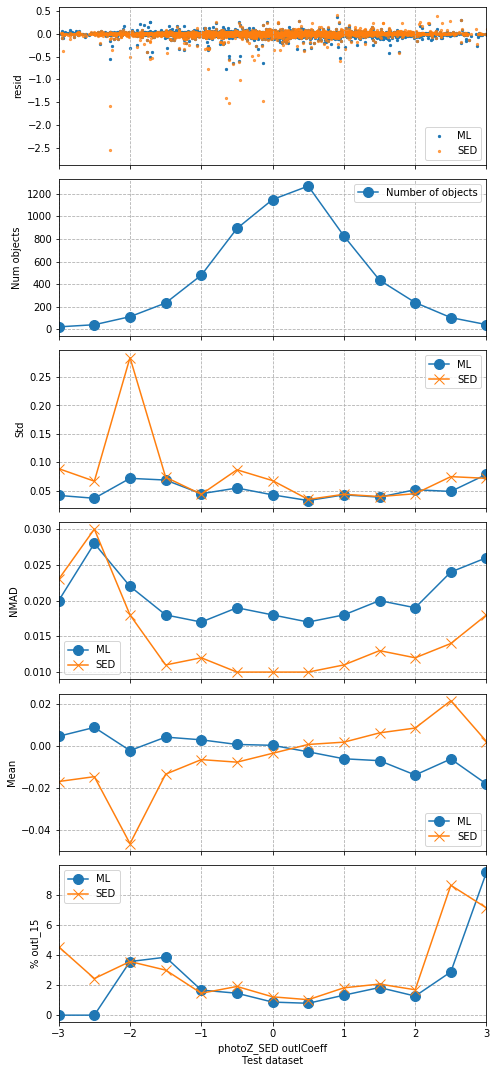

In [40]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_SED
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

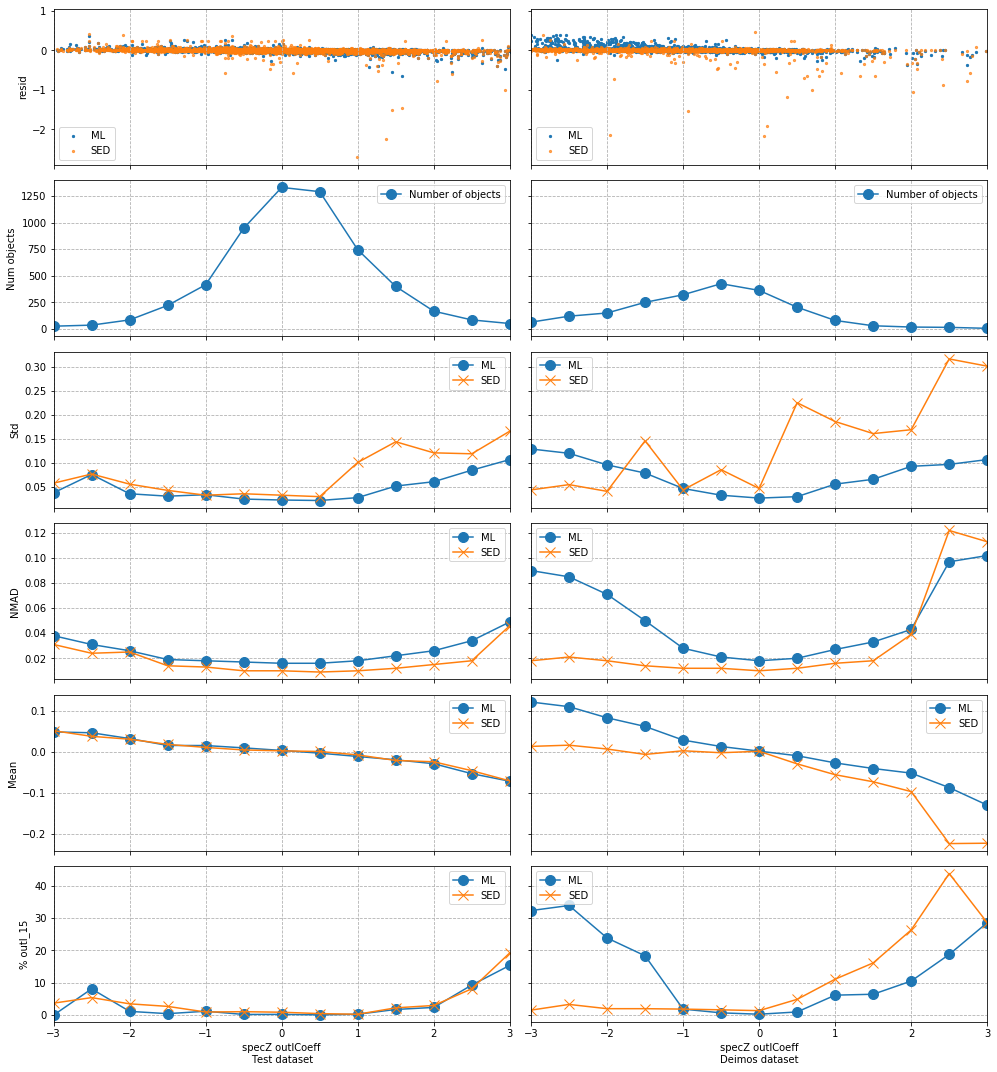

In [70]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=specZ
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

### PhotoZ_ML outlier filtering
<a id='PhotoZ_ML'>#PhotoZ_ML</a>

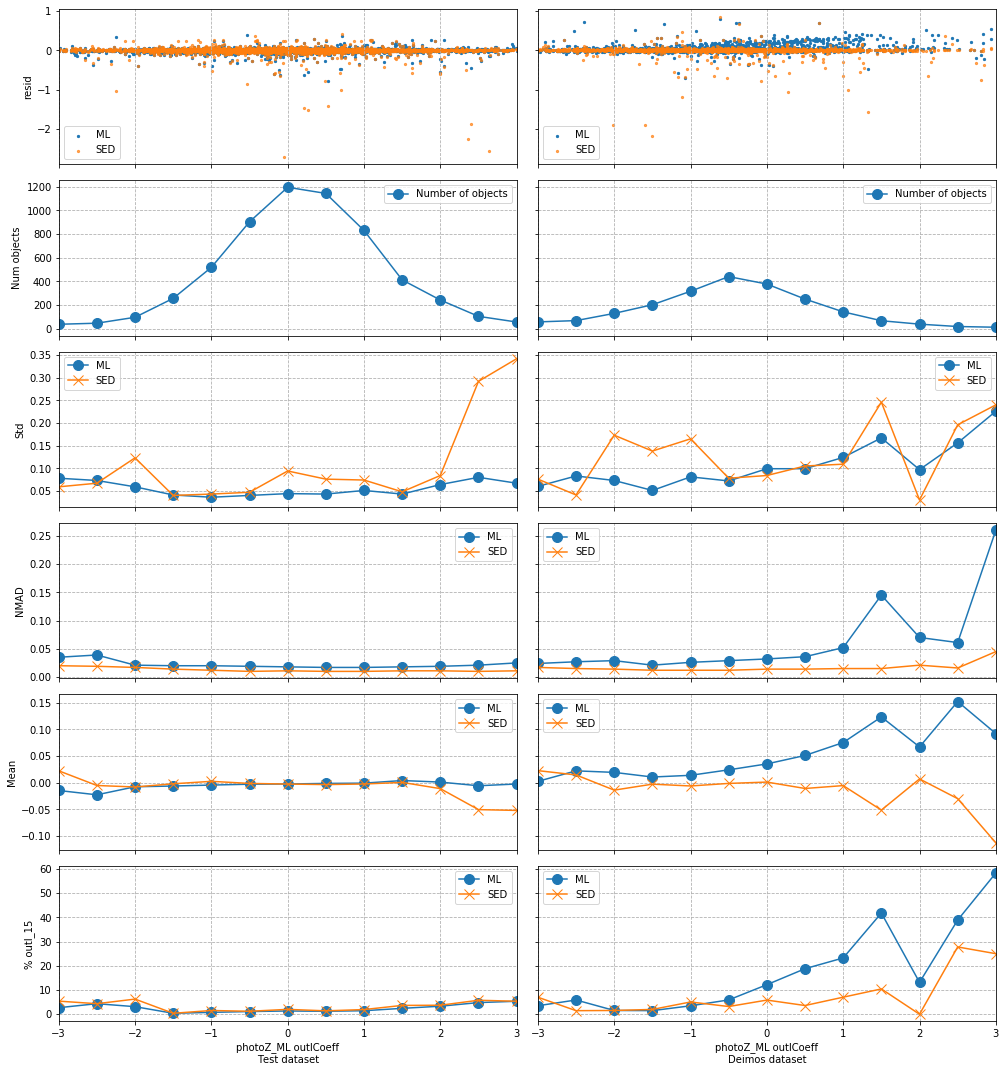

In [66]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_ML
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

### PhotoZ_SED outlier filtering
<a id='PhotoZ_SED'>#PhotoZ_SED</a>

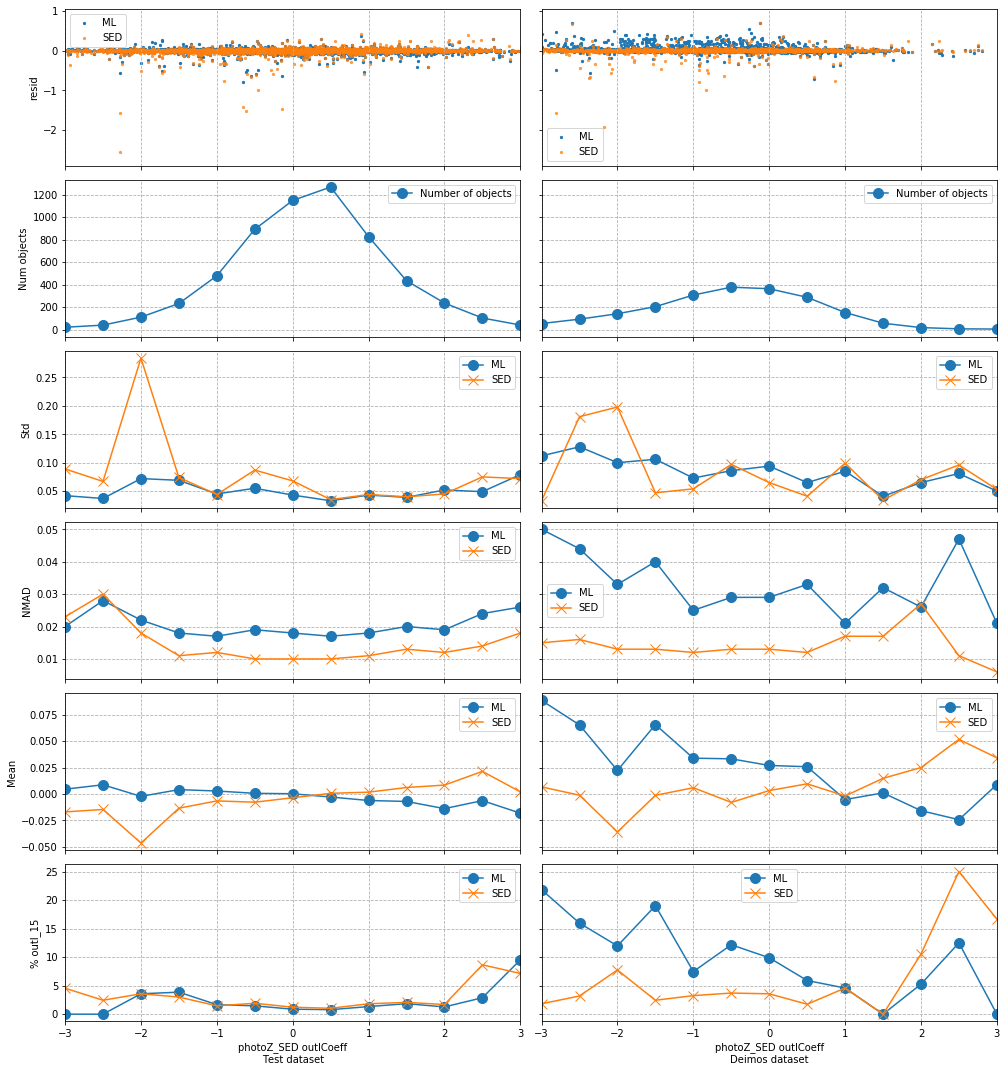

In [69]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=photoZ_SED
fig=plotStatsForOutlCoeff(data,case,stats,datasetNamesPlot)

In [141]:
def plotStatsForOutlCoeff2(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),13),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=12
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid',size=textSize)

    i=1
    for j,s in enumerate(stats):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c]['General']['binEdge'],s['outlCoeff_'+c]['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects',size=textSize)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            c=case[j]
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            s=s['outlCoeff_'+c][(s['outlCoeff_'+c]['General']['binEdge']>=lims[0]) & (s['outlCoeff_'+c]['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est,size=textSize)
    for j in range(len(datasetNames)):
        axs[-1][j].set_xlabel(case[j]+' outlCoeff\n'+ datasetNames[j]+' dataset',size=textSize)
    plt.tight_layout()
    return fig

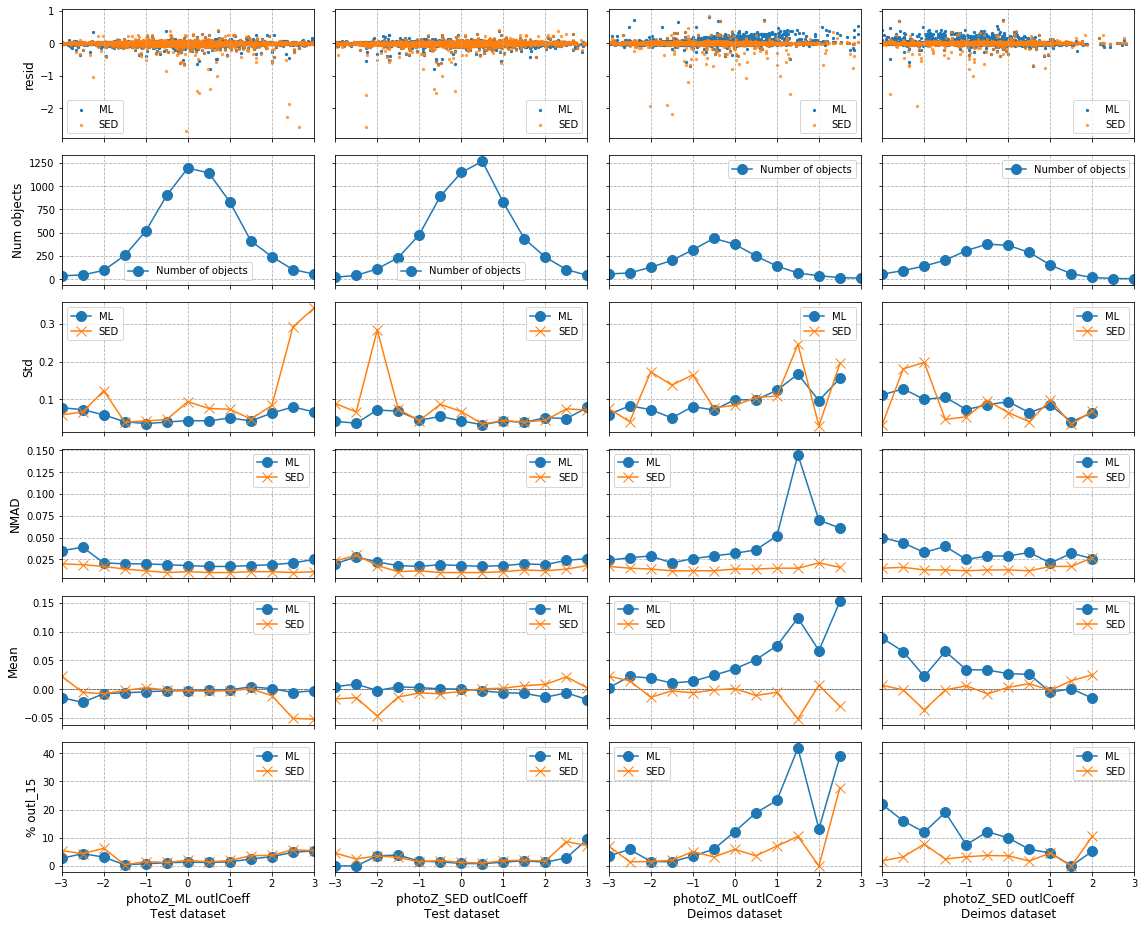

In [142]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]
case=[photoZ_ML,photoZ_SED,photoZ_ML,photoZ_SED,]
fig=plotStatsForOutlCoeff2(data,case,stats,datasetNamesPlot)

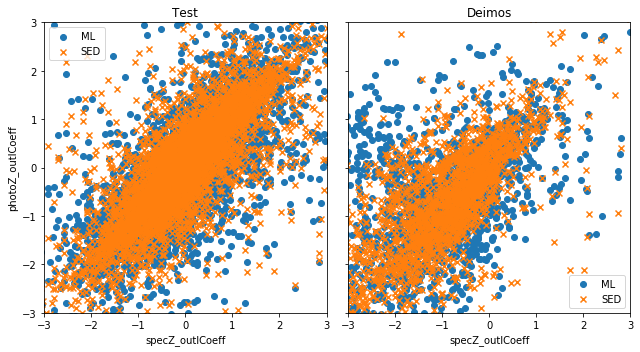

In [112]:
### Spec_z outl coeff vs Photo-z outl coeff ###
fig,axs=plt.subplots(1,2,figsize=(9,5),sharey='row',sharex='col')
datasetNames=['Test','Deimos']
for i,name in enumerate(datasetNames):
    axs[i].scatter(datasets[name][specZ+'_outlCoeff'],datasets[name][photoZ_ML+'_outlCoeff'],label='ML')
    axs[i].scatter(datasets[name][specZ+'_outlCoeff'],datasets[name][photoZ_SED+'_outlCoeff'],marker='x',label='SED')
    axs[i].set_xlabel('specZ_outlCoeff')
    
    axs[i].set_xlim((-3,3))
    axs[i].set_ylim((-3,3))
    axs[i].set_title(name)
    axs[i].legend()
axs[0].set_ylabel('photoZ_outlCoeff')
plt.tight_layout()

### ActivMap filtering
<a id='activMap'>#activMap</a>

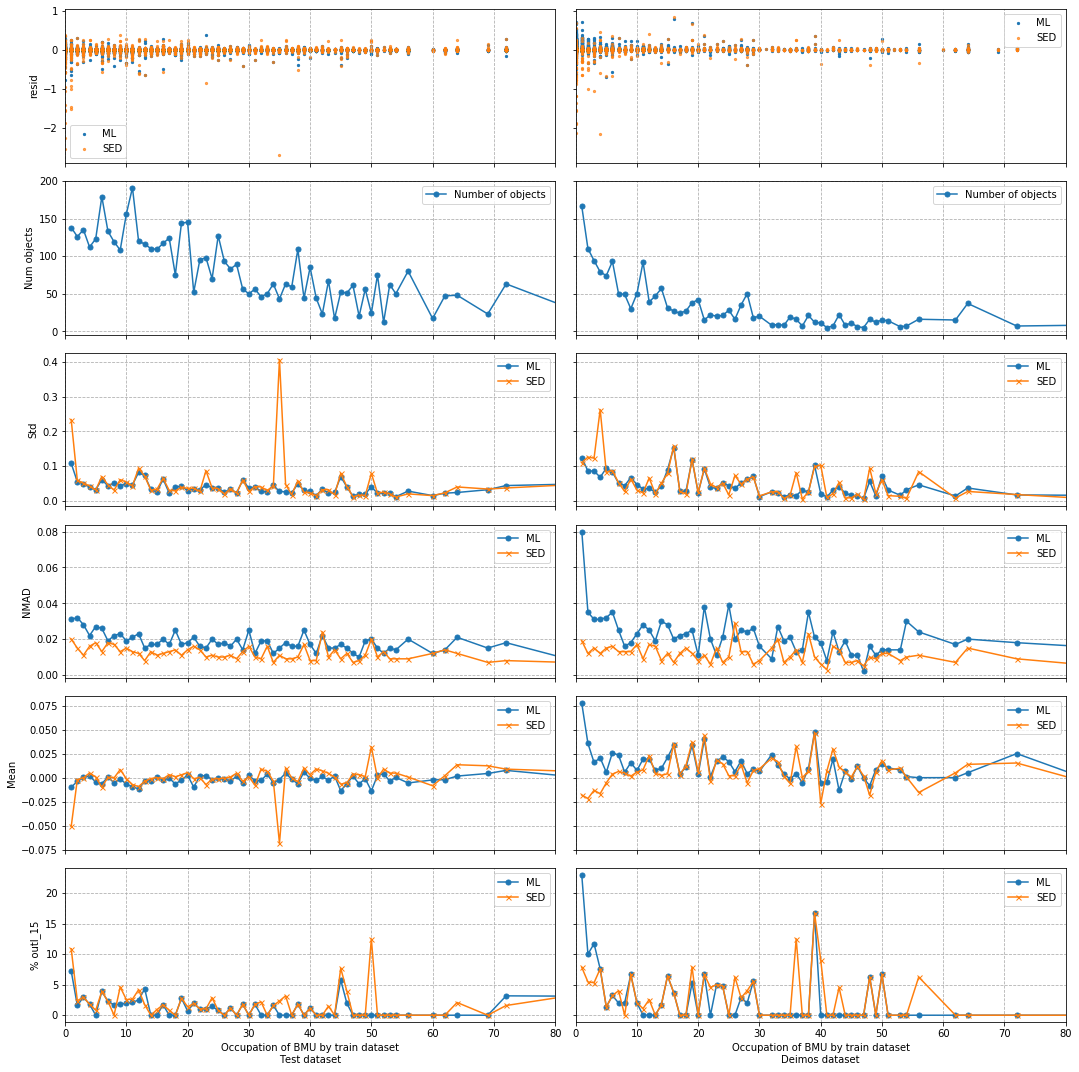

In [44]:
datasetNamesPlot=['Test','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
stats=[statAll[name] for name in datasetNamesPlot]

fig,axs=plt.subplots(6,2,figsize=(15,15),sharey='row',sharex='col')
estimators=['Std','NMAD','Mean','% outl_15']
i=0
for j,d in enumerate(data):
    axs[i][j].scatter(d['trainMapOccupation'],d[residML],s=5,label='ML')
    axs[i][j].scatter(d['trainMapOccupation'],d[residSED],s=5,label='SED',alpha=0.7)
    axs[i][j].grid(axis='x',linestyle ='--')
    axs[i][j].legend()
    axs[i][0].set_ylabel('resid')

i=1
for j,s in enumerate(stats):
    s=s['activMap'][s['activMap']['General']['Num objects']>=5]
    axs[i][j].plot(s['General']['trainMapOccupation'],s['General']['Num objects'],
                   markersize=5,label='Number of objects',marker='o')
    axs[i][j].grid(axis='x',linestyle ='--')
    axs[i][j].grid(axis='y',linestyle ='--')
    axs[i][j].legend()
    axs[i][0].set_ylabel('Num objects')

ii=2
for i,est in enumerate(estimators):
    for j,s in enumerate(stats):
        s=s['activMap'][s['activMap']['General']['Num objects']>=5]
        axs[i+ii][j].set_xlim(0,80)
        axs[i+ii][j].grid(axis='y',linestyle ='--')
        axs[i+ii][j].grid(axis='x',linestyle ='--')
        axs[i+ii][j].plot(s['General']['trainMapOccupation'],
                            s[residML][est],markersize=5,label='ML',marker='o')
        axs[i+ii][j].plot(s['General']['trainMapOccupation'],
                            s[residSED][est],markersize=5,label='SED',marker='x')
        axs[i+ii][j].legend()
    axs[i+ii][0].set_ylabel(est)
axs[-1][0].set_xlabel('Occupation of BMU by train dataset\n'+ datasetNamesPlot[0]+' dataset')
axs[-1][1].set_xlabel('Occupation of BMU by train dataset\n'+ datasetNamesPlot[1]+' dataset')
plt.tight_layout()

In [113]:
### Calculate statistics for objects with different outlCoeff after activMap cleaning###
cases=[specZ,photoZ_ML,photoZ_SED]
residCols=[residML,residSED,residML_SED]
bins=np.arange(-5, 5.5,step=0.5)
for name in statAll.keys():
    d=datasets[name]
    d=d[d['trainMapOccupation']>=5]
    for c in cases:
        if name=='Run':
            if c==specZ:
                continue
            else:
                statAll[name]['outlCoeff_'+c+'_activMapClean']=statByBins(d,binCol=c+'_outlCoeff',residCols=[residML_SED],bins=bins)
        else:
            statAll[name]['outlCoeff_'+c+'_activMapClean']=statByBins(d,binCol=c+'_outlCoeff',residCols=residCols,bins=bins)

In [115]:
statAll['Test'].keys()

dict_keys(['Basic', 'magBins', 'outlCoeff_specZ', 'outlCoeff_photoZ_ML', 'outlCoeff_photoZ_SED', 'activMap', 'magBins_specZ_filt', 'magBins_activMap', 'magBins_activMap_specZ', 'specZBins', 'outlCoeff_specZ_activMapClean', 'outlCoeff_photoZ_ML_activMapClean', 'outlCoeff_photoZ_SED_activMapClean'])

In [139]:
def plotStatsForOutlCoeff3(data,case,stats,datasetNames,lims=(-3,3)):
    fig,axs=plt.subplots(6,len(data),figsize=(4*len(data),13),sharey='row',sharex='col')
    if len(data)==1:
        axs=[[ax] for ax in axs]
    estimators=['Std','NMAD','Mean','% outl_15']
    i=0
    textSize=12
    for j,d in enumerate(data):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residML],s=5,label='ML')
        axs[i][j].scatter(d[c+'_outlCoeff'],d[residSED],s=5,label='SED',alpha=0.7)
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('resid',size=textSize)

    i=1
    for j,s in enumerate(stats):
        c=case[j]
        axs[i][j].set_xlim(lims)
        axs[i][j].plot(s['outlCoeff_'+c+'_activMapClean']['General']['binEdge'],s['outlCoeff_'+c+'_activMapClean']['General']['Num objects'],
                       markersize=10,label='Number of objects',marker='o')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].legend()
        axs[i][0].set_ylabel('Num objects',size=textSize)

    ii=2
    for i,est in enumerate(estimators):
        for j,s in enumerate(stats):
            c=case[j]
            axs[i+ii][j].grid(axis='y',linestyle ='--')
            axs[i+ii][j].grid(axis='x',linestyle ='--')
            if est=='Mean':
                axs[i+ii][j].axhline(0,color='black',ls='--',lw=0.5)
            s=s['outlCoeff_'+c+'_activMapClean'][(s['outlCoeff_'+c+'_activMapClean']['General']['binEdge']>=lims[0]) & 
                                (s['outlCoeff_'+c+'_activMapClean']['General']['binEdge']<=lims[1])]
            s=s.mask(s['General']['Num objects']<=15)
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residML][est],markersize=10,label='ML',marker='o')
            axs[i+ii][j].plot(s['General']['binEdge'],
                                s[residSED][est],markersize=10,label='SED',marker='x')
            axs[i+ii][j].set_xlim(lims)
            axs[i+ii][j].legend()
        axs[i+ii][0].set_ylabel(est,size=textSize)
    for j in range(len(datasetNames)):
        axs[-1][j].set_xlabel(case[j]+' outlCoeff\n'+ datasetNames[j]+' dataset',size=textSize)
    plt.tight_layout()
    return fig

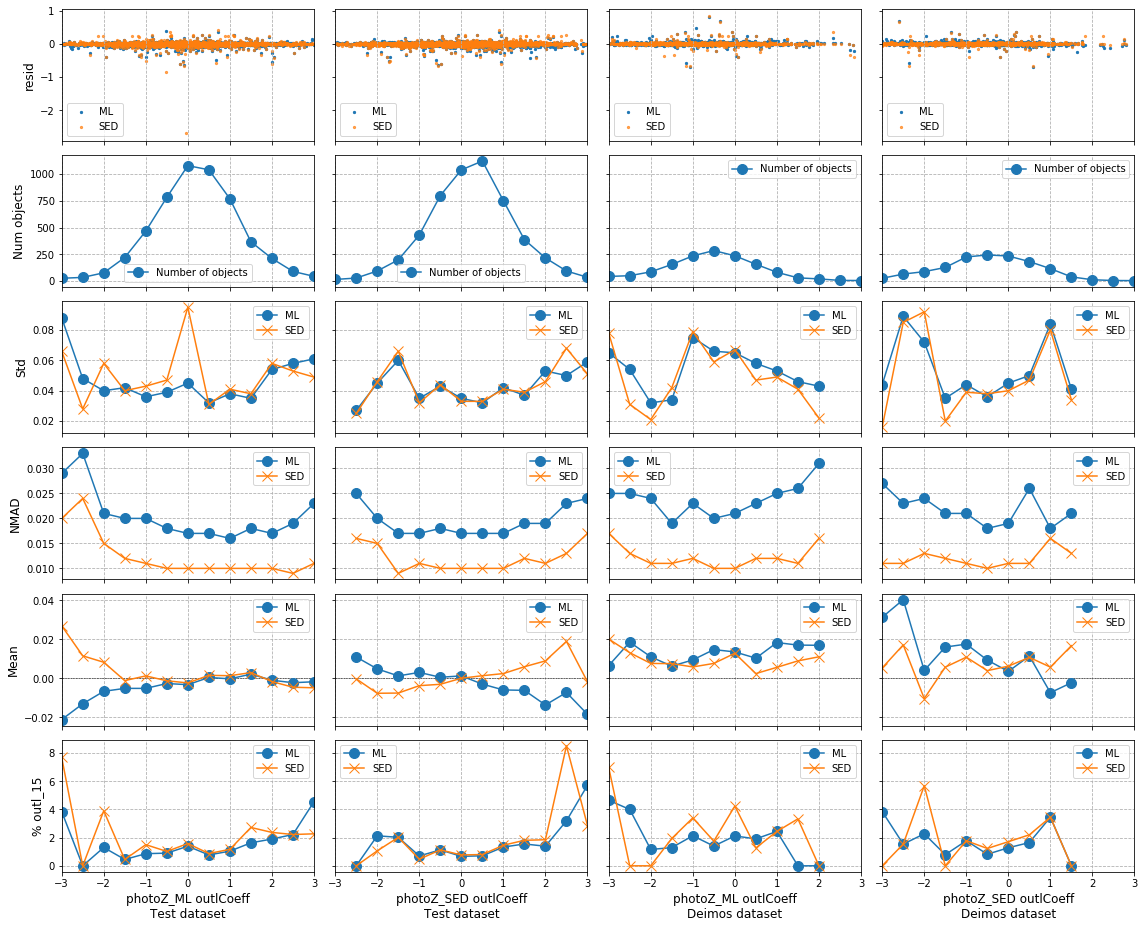

In [140]:
### Plot statistics for different outlCoeff ###
datasetNamesPlot=['Test','Test','Deimos','Deimos']
data=[datasets[name] for name in datasetNamesPlot]
data=[d[d['trainMapOccupation']>=5] for d in data]
stats=[statAll[name] for name in datasetNamesPlot]
case=[photoZ_ML,photoZ_SED,photoZ_ML,photoZ_SED]
fig=plotStatsForOutlCoeff3(data,case,stats,datasetNamesPlot,lims=(-3,3))

### General statistics table
<a id='statTab'>#statTab</a>

In [45]:
statAll['Test']['Basic'][['resid_ML','resid_SED','General']]

resid_ML                           \
                                               Std   NMAD    Mean % outl_15   
case                                                                          
No filtering                                 0.048  0.019 -0.0023      1.64   
trainMapOccupation>5                         0.041  0.018 -0.0021      1.18   
specZ_outlCoeff<=1                           0.025  0.017  0.0002      0.19   
specZ_outlCoeff + occupation filters         0.022  0.016 -0.0002      0.05   
photoZ_ML_outlCoeff<=1                       0.045  0.018  -0.002      1.28   
photoZ_ML_outlCoeff + occupation filters     0.039  0.017 -0.0015      1.06   
photoZ_SED_outlCoeff<=1                      0.043  0.018  -0.002      1.06   
photoZ_SED_outlCoeff + occupation filters    0.038  0.017 -0.0016      0.94   

                                          resid_SED                           \
                                                Std   NMAD    Mean % outl_15   
case                                                                           
No filtering                                  0.094  0.011 -0.0041      2.23   
trainMapOccupation>5                          0.058   0.01  0.0001      1.49   
specZ_outlCoeff<=1                            0.052   0.01  0.0006       0.7   
specZ_outlCoeff + occupation filters           0.05  0.009  0.0018      0.35   
photoZ_ML_outlCoeff<=1                        0.077   0.01 -0.0026      1.65   
photoZ_ML_outlCoeff + occupation filters      0.062   0.01 -0.0003      1.17   
photoZ_SED_outlCoeff<=1                       0.061   0.01 -0.0021      1.43   
photoZ_SED_outlCoeff + occupation filters     0.038   0.01  0.0002      0.99   

                                              General  
                                          Num objects  
case                                                   
No filtering                                   5967.0  
trainMapOccupation>5                           5167.0  
specZ_outlCoeff<=1                             4311.0  
specZ_outlCoeff + occupation filters           3761.0  
photoZ_ML_outlCoeff<=1                         4071.0  
photoZ_ML_outlCoeff + occupation filters       3587.0  
photoZ_SED_outlCoeff<=1                        4133.0  
photoZ_SED_outlCoeff + occupation filters      3624.0

In [46]:
statAll['Deimos']['Basic'][['General','resid_ML','resid_SED']]

General resid_ML                 \
                                          Num objects      Std   NMAD    Mean   
case                                                                            
No filtering                                   2255.0    0.099  0.032  0.0347   
trainMapOccupation>5                           1382.0    0.058  0.023  0.0127   
specZ_outlCoeff<=1                             1075.0    0.035   0.02  0.0018   
specZ_outlCoeff + occupation filters            758.0    0.025  0.018  0.0017   
photoZ_ML_outlCoeff<=1                         1209.0    0.095  0.033  0.0392   
photoZ_ML_outlCoeff + occupation filters        724.0    0.064  0.022  0.0136   
photoZ_SED_outlCoeff<=1                        1183.0    0.085  0.029  0.0245   
photoZ_SED_outlCoeff + occupation filters       741.0    0.046   0.02  0.0063   

                                                    resid_SED                 \
                                          % outl_15       Std   NMAD    Mean   
case                                                                           
No filtering                                  10.86     0.142  0.014 -0.0082   
trainMapOccupation>5                            2.1     0.059  0.012  0.0085   
specZ_outlCoeff<=1                             1.02     0.127  0.011 -0.0103   
specZ_outlCoeff + occupation filters           0.13     0.031   0.01  0.0038   
photoZ_ML_outlCoeff<=1                        12.57      0.09  0.013 -0.0031   
photoZ_ML_outlCoeff + occupation filters       1.93      0.06  0.011   0.008   
photoZ_SED_outlCoeff<=1                        8.96     0.078  0.013  0.0005   
photoZ_SED_outlCoeff + occupation filters      1.48     0.044  0.011  0.0075   

                                                     
                                          % outl_15  
case                                                 
No filtering                                   5.06  
trainMapOccupation>5                           2.68  
specZ_outlCoeff<=1                             2.88  
specZ_outlCoeff + occupation filters           0.92  
photoZ_ML_outlCoeff<=1                         4.55  
photoZ_ML_outlCoeff + occupation filters       2.62  
photoZ_SED_outlCoeff<=1                         3.3  
photoZ_SED_outlCoeff + occupation filters      1.89

In [47]:
statAll['Deimos']['Basic'][['residML_SED','General']]

residML_SED                 \
                                                  Std   NMAD    Mean   
case                                                                   
No filtering                                    0.102  0.033  0.0355   
trainMapOccupation>5                            0.047  0.023  0.0031   
specZ_outlCoeff<=1                               0.07  0.023  0.0049   
specZ_outlCoeff + occupation filters            0.036   0.02 -0.0028   
photoZ_ML_outlCoeff<=1                          0.088  0.034  0.0392   
photoZ_ML_outlCoeff + occupation filters        0.043  0.022  0.0048   
photoZ_SED_outlCoeff<=1                         0.072   0.03  0.0224   
photoZ_SED_outlCoeff + occupation filters        0.03  0.022 -0.0015   

                                                        General  
                                          % outl_15 Num objects  
case                                                             
No filtering                                  11.35      2255.0  
trainMapOccupation>5                           1.52      1382.0  
specZ_outlCoeff<=1                             2.88      1075.0  
specZ_outlCoeff + occupation filters           0.92       758.0  
photoZ_ML_outlCoeff<=1                        11.75      1209.0  
photoZ_ML_outlCoeff + occupation filters       0.97       724.0  
photoZ_SED_outlCoeff<=1                        7.44      1183.0  
photoZ_SED_outlCoeff + occupation filters      0.27       741.0

In [48]:
statAll['Run']['Basic']

residML_SED                 \
                                                  Std   NMAD    Mean   
case                                                                   
No filtering                                    0.238  0.129  0.1373   
trainMapOccupation>5                            0.083  0.028 -0.0019   
photoZ_ML_outlCoeff<=1                          0.225   0.11  0.1243   
photoZ_ML_outlCoeff + occupation filters         0.08  0.028 -0.0029   
photoZ_SED_outlCoeff<=1                         0.206  0.101  0.1217   
photoZ_SED_outlCoeff + occupation filters       0.056  0.026 -0.0031   

                                                        General  
                                          % outl_15 Num objects  
case                                                             
No filtering                                  40.23    194509.0  
trainMapOccupation>5                           3.59     43279.0  
photoZ_ML_outlCoeff<=1                        37.76    137152.0  
photoZ_ML_outlCoeff + occupation filters       3.48     33296.0  
photoZ_SED_outlCoeff<=1                       34.93    146773.0  
photoZ_SED_outlCoeff + occupation filters      2.17     35189.0

### Statistics for magnitude binning
<a id='magBin'>#magBin</a>

In [49]:
def plotBinnedStats(stats,estimators,residCols,cases,binCol,xlim=None):
    colorBlindPalette=['#000000','#E69F00','#009E73','#0072B2','#D55E00','#56B4E9','#F0E442','#CC79A7']
    fig, axs = plt.subplots(len(estimators)+1, len(residCols),figsize=(7*len(residCols),4*len(estimators)),sharey='row',sharex='col')
    if len(residCols)==1:
        axs=[[ax] for ax in axs]
    
    i=0
    for j, c in enumerate(residCols):
        axs[i][j].grid(axis='y',linestyle ='--')
        axs[i][j].grid(axis='x',linestyle ='--')
        axs[i][j].set_ylabel('Number of objects',size=12)
        for k,case in enumerate(cases):
            stat=stats[case]
            if xlim!=None:
                stat=stat[(stat['General']['binEdge']>=xlim[0]) & (stat['General']['binEdge']<=xlim[1])]
            marker='o'
            if c=='resid_SED':
                marker='x'
            axs[i][j].plot(stat['General']['binEdge'],stat['General']['Num objects'],
                           label=case,marker=marker,markersize=10-2*k,c=colorBlindPalette[k])
        axs[i][j].legend()
        axs[i][j].set_xlim(xlim)
    
    for i,est in enumerate(estimators):
        for j, c in enumerate(residCols):
            axs[i+1][j].grid(axis='y',linestyle ='--')
            axs[i+1][j].grid(axis='x',linestyle ='--')
            axs[i+1][j].set_ylabel(est+' '+c,size=12)
            for k,case in enumerate(cases):
                stat=stats[case]
                if xlim!=None:
                    stat=stat[(stat['General']['binEdge']>=xlim[0]) & (stat['General']['binEdge']<=xlim[1])]
                marker='o'
                if c=='resid_SED':
                    marker='x'
                axs[i+1][j].plot(stat['General']['binEdge'],stat[c][est],
                               label=case,marker=marker,markersize=10-2*k,c=colorBlindPalette[k])
            axs[i+1][j].legend()
            axs[i+1][j].set_xlim(xlim)
    
    axs[-1][0].set_xlabel(binCol,size=12)
    if len(residCols)>1:
        axs[-1][1].set_xlabel(binCol,size=12)
    plt.tight_layout()
    return fig

In [50]:
### Calculate statistics by specZ bins ###
numBins=7
bins=np.linspace(0, 1.2, numBins)
for name in statAll.keys():
    if name=='Run':
        continue
    else:
        residCols=[residML,residSED,residML_SED]
    statAll[name]['specZBins']=statByBins(datasets[name],binCol=specZ,residCols=residCols,bins=bins)

In [51]:
statAll['Test']['specZBins']

resid_ML                          resid_SED                           \
         Std   NMAD    Mean % outl_15       Std   NMAD    Mean % outl_15   
0.2      0.1  0.027 -0.0416      8.29     0.278  0.012 -0.0552      7.82   
0.4    0.043  0.016 -0.0081      1.31     0.056  0.008 -0.0034      1.94   
0.6    0.038  0.016  0.0003      1.04     0.067   0.01 -0.0002      2.07   
0.8    0.036  0.018  0.0001      1.01     0.052  0.012  0.0002      1.48   
1.0    0.032  0.019  0.0041      0.55     0.044  0.014  0.0057       1.2   
1.2    0.051  0.028  0.0292      2.99     0.094  0.027 -0.0068      3.53   

    residML_SED                              General          
            Std   NMAD    Mean % outl_15 Num objects binEdge  
0.2       0.083  0.025  -0.006      2.84       422.0     0.2  
0.4        0.03  0.017 -0.0056      0.69      1445.0     0.4  
0.6        0.05  0.017 -0.0018      1.21      1158.0     0.6  
0.8       0.039  0.017 -0.0015      0.74      1489.0     0.8  
1.0       0.037  0.019 -0.0029      0.55      1085.0     1.0  
1.2       0.078   0.03  0.0296      4.35       368.0     1.2

Text(0.525, 1.03, 'Test dataset')

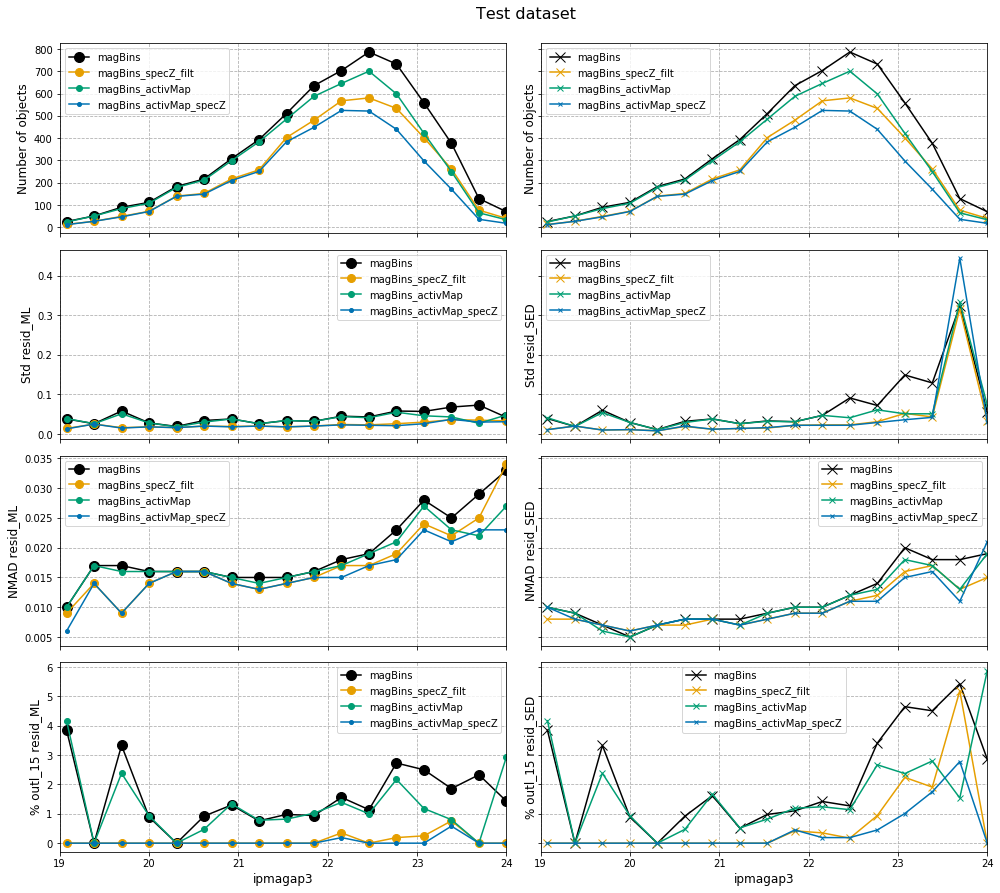

In [54]:
keyStat='Test'
stats=statAll[keyStat]

estimators=['Std','NMAD','% outl_15']
cases=['magBins','magBins_specZ_filt','magBins_activMap','magBins_activMap_specZ']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML,residSED],cases=cases,binCol=binCol,xlim=(19,24))
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.03, x=0.525)

Text(0.525, 1.03, 'Deimos dataset')

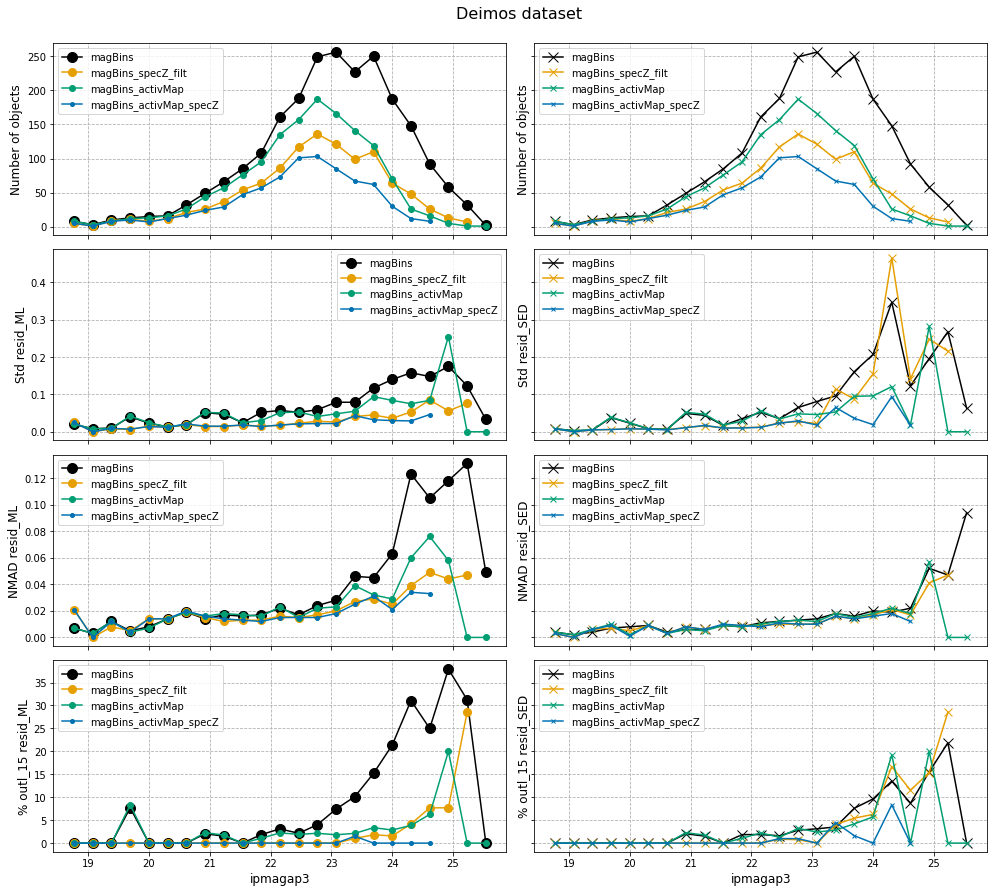

In [58]:
keyStat='Deimos'
stats=statAll[keyStat]

estimators=['Std','NMAD','% outl_15']
cases=['magBins','magBins_specZ_filt','magBins_activMap','magBins_activMap_specZ']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML,residSED],cases=cases,binCol=binCol)
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.03, x=0.525)

Text(0.56, 1.02, 'Run dataset')

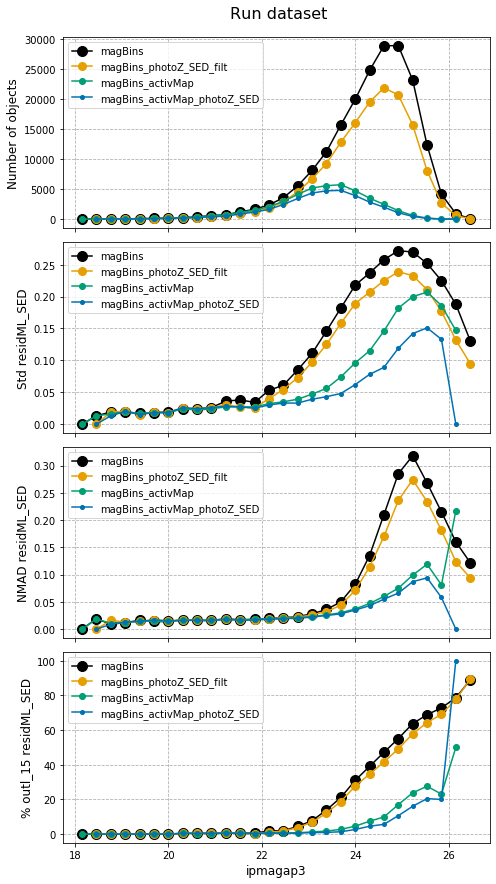

In [59]:
keyStat='Run'
stats=statAll[keyStat]

estimators=['Std','NMAD','% outl_15']
cases=['magBins','magBins_photoZ_SED_filt','magBins_activMap','magBins_activMap_photoZ_SED']
binCol='ipmagap3'
fig=plotBinnedStats(stats,estimators,residCols=[residML_SED],cases=cases,binCol=binCol)
fig.suptitle(keyStat+' dataset', fontsize=16, y=1.02,x=0.56)